# Calculate skill scores for offline tracer advection with ROMS



## TODOS

* cast in terms of normalized time scale also
* print final ss for all relevant runs
 * which runs to just say in text
  * avg vs his
  * Aksoff different background values
* plot ss vs run time vs storage time as a 3d plot
 * how to present storage normalized. As a function of number of grid nodes horizontally and vertically (since some variables are 3d and some 4d)
* calculate conservation on and offline

In [3]:
import xarray as xr
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pandas as pd
import os
# import hvplot.xarray
# import geoviews as gv
import cartopy
import cmocean.cm as cmo
import netCDF4 as netCDF
import xgcm

# chunks = {'ocean_time': 50}#, 's_rho': 50}
chunks = {'ocean_time': 1}
# chunks = {'s_rho': 1}

# chunks = {'s_rho': 1}

/scratch/user/kthyng/.conda/envs/cart/lib/python3.7/site-packages/distributed/utils.py:133: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [4]:
import dask
from dask.distributed import Client

# client = Client(n_workers=7, threads_per_worker=2)#, memory_limit='20GB')
client = Client()#, memory_limit='20GB')
# client = Client(n_workers=1, threads_per_worker=7)  # i have multiple cores on one machine so use threads
client

/scratch/user/kthyng/.conda/envs/cart/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:46671 Dashboard: http://127.0.0.1:42613/status,Cluster Workers: 7 Cores: 7 Memory: 32.21 GB


In [5]:
def add_depths(ds):
#     Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
#     z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta
    Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
    z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho', transpose_coords=False)
#     ds.coords['z_rho'] = z_rho.transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho', transpose_coords=False)
    return ds

def setup_grid(ds):
    # Create the grid
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
        'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
        's':{'center':'s_rho', 'outer':'s_w'}}

    grid = xgcm.Grid(ds, coords=coords, periodic=[])
    return ds, grid

## Set up parameters for simulations





## Read in on and offline output


Times

nhis 100, dt 10
4, 4, 28, 27
dyeon.nbytes/1e9 = 1.7303GB
0.034606GB surface only

nhis 10, dt 10
45, 40, surface only, time chunk 10: 30, 30, 80, 200
time chunk 50: 25, 40, 70, 200
dyeon.nbytes/1e9=17GB, 0.3460028 surface only
dyeon.isel(ocean_time=0).nbytes/1e9 = 0.00286



First downscale all the online files, which have potential very high output rates.

In [38]:
iy = [10,75]; ix = [5,115]


nhiss = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
whichadvects = ['U3C4','MPDATA']
akss = [1e-6, 1e-3]  # vary background Aks values when Aks isn't being forced directly
aksflags = ['Akson', 'Aksoff']
clminputs = ['his', 'avg']

baseon = '/scratch/group/csomio/CSOMIO/oil_03'
baseoff = '/scratch/group/csomio/CSOMIO/oil_off'

for i, nhis in enumerate(nhiss):
    dd = int(500/nhis)
    if nhis>500:  # for nhis=1000,2000,5000, output is at that frequency which is lower than 500
        dd = 1
        
    for whichadvect in whichadvects:
        # whether to force offline from online his or online avg
        for clminput in clminputs:
            
            locon = '%s/output_ss/%s/nhis%i/oil_03_%s.nc' % (baseon,whichadvect,nhis,clminput)
            zarrname = locon.split('.')[0]
            print(zarrname)
            
            if not os.path.exists(zarrname):  # don't redo
                print('processing...')
                dson = xr.open_dataset(locon, decode_times=False, chunks=chunks);

                dson = add_depths(dson)
                dson, grid = setup_grid(dson)  
                dzon = grid.diff(dson.z_w, 's')

                dx = 1/dson.pm
                dy = 1/dson.pn
                dyeon = (dson['dye_01']*dx*dy*dzon)

                dyeon.isel(ocean_time=slice(0,-1,dd), eta_rho=slice(iy[0],iy[1]), 
                           xi_rho=slice(ix[0],ix[1])).to_dataset(name='dye_01').to_zarr(zarrname, mode='w')
            else:
                print('already done, moving on.\n')


/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis1/oil_03_his
already done, moving on.

/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis1/oil_03_avg
already done, moving on.

/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis1/oil_03_his
already done, moving on.

/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis1/oil_03_avg
already done, moving on.

/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis2/oil_03_his
already done, moving on.

/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis2/oil_03_avg
already done, moving on.

/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis2/oil_03_his
already done, moving on.

/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis2/oil_03_avg
already done, moving on.

/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis5/oil_03_his
already done, moving on.

/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis5/oil_03_avg
already done, moving on.

/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA

In [412]:
tend = 13.5

locoff = '/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis1/oil_off_his_dt1.nc'
dsoff = xr.open_dataset(locoff, decode_times=False, chunks=chunks)
dsoff['ocean_time'] = (dsoff.ocean_time - dsoff.ocean_time[0])/86400
dfhis = pd.DataFrame(index=dsoff.sel(ocean_time=slice(0,tend)).ocean_time)


# locoff = '/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/avg/nhis1/oil_off_avg_dt1.nc'
# dsoff = xr.open_dataset(locoff, decode_times=False, chunks=chunks)
# dsoff['ocean_time'] = (dsoff.ocean_time - dsoff.ocean_time[0])/86400
dfavg = pd.DataFrame(index=dsoff.sel(ocean_time=slice(0,tend)).ocean_time)


In [ ]:
NEED TO RERUN ANALYSIS WITHOUT SUBTRACTING TIME FIRST. SUBTRACT TIME AT THE END INSTEAD.

In [413]:
iy = [10,75]; ix = [5,115]


# nhiss = [1, 2, 5, 10, 20, 50, 100, 200, 500]
nhiss = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
whichadvects = ['U3C4','MPDATA']

# nhissoff = [1,10,100]  # [1, 2, 5, 10, 20, 50, 100, 200, 500]
akss = [1e-6, 1e-3]  # vary background Aks values when Aks isn't being forced directly
aksflags = ['Akson', 'Aksoff']
clminputs = ['his', 'avg']

baseon = '/scratch/group/csomio/CSOMIO/oil_03'
baseoff = '/scratch/group/csomio/CSOMIO/oil_off'


for clminput in clminputs:
    
    if clminput == 'his':
        df = dfhis
    elif clminput == 'avg':
        df = dfavg
    dfname = 'output_ss/df%s.csv' % clminput
           
    for whichadvect in whichadvects:
        # whether to force offline from online his or online avg
        for i, nhis in enumerate(nhiss):
            dd = int(500/nhis)
            
            locon = '%s/output_ss/%s/nhis%i/oil_03_%s' % (baseon,whichadvect,nhis,clminput)
            dson = xr.open_zarr(locon, decode_times=False)#, chunks=chunks)
#             dson['ocean_time'] = (dson.ocean_time - dson.ocean_time[0])/86400
            print(locon)            
            
            denomname = '%s_denom.csv' % locon
           
            if os.path.exists(denomname):
                denom = pd.read_csv(denomname, index_col='ocean_time')
            else:
                # calculate denominator for skill score which is the same for all derivative offline runs
                denom = np.sqrt(((dson.dye_01)**2).mean(('s_rho','eta_rho', 'xi_rho')))

                # save 
                denom = denom.to_dataframe(name='denom')
                denom.to_csv(denomname)           
                
            # for each nhis, the possible time step dts to run is from 1 up to equal to clm
            dts = nhiss[:i+1]
            
            if nhis == 5:
                dts = [1]
            elif nhis == 50:
                dts = [1,2,5,10]
                
            # loop over sim time step
            for dt in dts:

            
                    if dt >= 50:  # dt=100 creates instabilities and results are invalid
                        continue

                    # Aks forcing can be turned on or off
                    for aksflag in aksflags:
                        if aksflag == 'Aksoff':
                            for aks in akss:
                                if nhis>=1000 and aks == 1e-3:
                                    continue
                                exp = int(abs(np.log10(aks)))
                                outdir = '%s/output_ss/%s/%s/Aksbak%i/%s/nhis%i' % (baseoff,whichadvect,aksflag,exp,clminput,nhis)                                
                                locoff = '%s/oil_off_%s_dt%i.nc' % (outdir,clminput,dt)
                                print(locoff)
                                name = '%s_%s_Aksbak%s_%s_nhis%s_dt%s' % (whichadvect,aksflag,exp,clminput,nhis,dt)

                                numname = '%s_num.csv' % locoff.split('.')[0]  # num same for persist
                            
                                if os.path.exists(numname):
                                    num = pd.read_csv(numname, index_col='ocean_time')
                                else:
                                
                                    dsoff = xr.open_dataset(locoff, decode_times=False)#, chunks=chunks)
    #                                     dsoff['ocean_time'] = (dsoff.ocean_time - dsoff.ocean_time[0])/86400

                                    dsoff = add_depths(dsoff)
                                    dsoff, grid = setup_grid(dsoff)  
                                    dzoff = grid.diff(dsoff.z_w, 's')
                                    dx = 1/dsoff.pm
                                    dy = 1/dsoff.pn

                                    dyeoff = (dsoff['dye_01']*dx*dy*dzoff)
                                    dyeoff = dyeoff.isel(ocean_time=slice(0,-1), eta_rho=slice(iy[0],iy[1]), 
                                                xi_rho=slice(ix[0],ix[1]))#.to_dataset(name='dye_01').to_zarr(zarrname, mode='w')
                                    # interpolate to match online run
                                    dyeoff = dyeoff.interp(ocean_time=dson.ocean_time)         

                                    num = np.sqrt(((dyeoff - dson.dye_01)**2).mean(('s_rho','eta_rho', 'xi_rho')))

                                    # save 
                                    num = num.to_dataframe(name='num')
                                    num.to_csv(numname)
                        
                                ssname = '%s_ss.csv' % locoff.split('.')[0]

                                if os.path.exists(ssname):
                                    skill = pd.read_csv(ssname, index_col='ocean_time')# np.loadtxt(ssname)
                                else:
                                    skill = (1-num/denom.values)*100
                                    skill.index = (skill.index - skill.index[0])/86400
                                    # save 
                                    skill.to_csv(ssname)

                                df[name] = skill[0:tend]
#                                 if nhis>500 or nhis==200:
                                df[name] = df[name].interpolate(method='index')
                
                        else:
                            outdir = '%s/output_ss/%s/%s/%s/nhis%i' % (baseoff,whichadvect,aksflag,clminput,nhis)
                            locoff = '%s/oil_off_%s_dt%i.nc' % (outdir,clminput,dt)
                            print(locoff)
                            name = '%s_%s_%s_nhis%s_dt%s' % (whichadvect,aksflag,clminput,nhis,dt)
                            

                            numname = '%s_num.csv' % locoff.split('.')[0]  # num same for persist

                            if os.path.exists(numname):
                                num = pd.read_csv(numname, index_col='ocean_time')
                            else:

                                dsoff = xr.open_dataset(locoff, decode_times=False)#, chunks=chunks)
    #                             dsoff['ocean_time'] = (dsoff.ocean_time - dsoff.ocean_time[0])/86400

                                dsoff = add_depths(dsoff)
                                dsoff, grid = setup_grid(dsoff)  
                                dzoff = grid.diff(dsoff.z_w, 's')
                                dx = 1/dsoff.pm
                                dy = 1/dsoff.pn

                                dyeoff = (dsoff['dye_01']*dx*dy*dzoff)
                                dyeoff = dyeoff.isel(ocean_time=slice(0,-1), eta_rho=slice(iy[0],iy[1]), 
                                            xi_rho=slice(ix[0],ix[1]))#.to_dataset(name='dye_01').to_zarr(zarrname, mode='w')
                                # interpolate to match online run
                                dyeoff = dyeoff.interp(ocean_time=dson.ocean_time)         

                                num = np.sqrt(((dyeoff - dson.dye_01)**2).mean(('s_rho','eta_rho', 'xi_rho')))

                                # save 
                                num = num.to_dataframe(name='num')
                                num.to_csv(numname)

                            ssname = '%s_ss.csv' % locoff.split('.')[0]

                            if os.path.exists(ssname):
                                skill = pd.read_csv(ssname, index_col='ocean_time')# np.loadtxt(ssname)
                            else:
                                skill = (1-num/denom.values)*100
                                skill.index = (skill.index - skill.index[0])/86400
                                # save 
                                skill.to_csv(ssname)

                            df[name] = skill[0:tend]
#                             if nhis>500 or nhis==200:
                            df[name] = df[name].interpolate(method='index')
                        
    df.to_csv(dfname)


/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis1/oil_03_his
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis1/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis1/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis1/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis2/oil_03_his
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis2/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis2/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis2/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMI

/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis500/oil_03_his
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis500/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis500/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis500/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis500/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis500/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis500/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis500/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis500/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis500/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis500/oil_o

/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis20/oil_off_his_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis20/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis20/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis20/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis50/oil_03_his
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis50/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis50/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/his/nhis50/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis50/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis50/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/

/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis2000/oil_off_his_dt20.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis5000/oil_03_his
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis5000/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis5000/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis5000/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis5000/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis5000/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis5000/oil_off_his_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/his/nhis5000/oil_off_his_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/his/nhis5000/oil_off_his_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDA

/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/avg/nhis200/oil_off_avg_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/avg/nhis200/oil_off_avg_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/avg/nhis200/oil_off_avg_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/avg/nhis200/oil_off_avg_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/avg/nhis200/oil_off_avg_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/avg/nhis200/oil_off_avg_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/avg/nhis200/oil_off_avg_dt10.nc


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/avg/nhis200/oil_off_avg_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/avg/nhis200/oil_off_avg_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/avg/nhis200/oil_off_avg_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/avg/nhis200/oil_off_avg_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/avg/nhis200/oil_off_avg_dt20.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis500/oil_03_avg
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/avg/nhis500/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/avg/nhis500/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/avg/nhis500/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/avg/nhis500/oil_off_avg_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/avg

/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis20/oil_off_avg_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis20/oil_off_avg_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis20/oil_off_avg_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis20/oil_off_avg_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis20/oil_off_avg_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis20/oil_off_avg_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis20/oil_off_avg_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis20/oil_off_avg_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak3/avg/nhis20/oil_off_avg_dt20.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis50/oil_03_avg
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson

/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis2000/oil_off_avg_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis2000/oil_off_avg_dt5.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis2000/oil_off_avg_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis2000/oil_off_avg_dt10.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis2000/oil_off_avg_dt20.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis2000/oil_off_avg_dt20.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/MPDATA/nhis5000/oil_03_avg
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis5000/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksoff/Aksbak6/avg/nhis5000/oil_off_avg_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Akson/avg/nhis5000/oil_off_avg_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/MPDATA/Aksof

## Calculate skill score compared to persistence

save num and denom each time

In [414]:
tend = 13.5

locoff = '/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis1/oil_off_his_dt1.nc'
dsoff = xr.open_dataset(locoff, decode_times=False, chunks=chunks)
dsoff['ocean_time'] = (dsoff.ocean_time - dsoff.ocean_time[0])/86400
dfhis = pd.DataFrame(index=dsoff.sel(ocean_time=slice(0,tend)).ocean_time)

# locoff = '/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/avg/nhis1/oil_off_avg_dt1.nc'
# dsoff = xr.open_dataset(locoff, decode_times=False, chunks=chunks)
# dsoff['ocean_time'] = (dsoff.ocean_time - dsoff.ocean_time[0])/86400
dfavg = pd.DataFrame(index=dsoff.sel(ocean_time=slice(0,tend)).ocean_time)


In [415]:
iy = [10,75]; ix = [5,115]


# nhiss = [1, 2, 5, 10, 20, 50, 100, 200, 500]
nhiss = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
whichadvects = ['U3C4','MPDATA']

# nhissoff = [1,10,100]  # [1, 2, 5, 10, 20, 50, 100, 200, 500]
akss = [1e-6, 1e-3]  # vary background Aks values when Aks isn't being forced directly
aksflags = ['Akson', 'Aksoff']
clminputs = ['avg']# ['his', 'avg']

baseon = '/scratch/group/csomio/CSOMIO/oil_03'
baseoff = '/scratch/group/csomio/CSOMIO/oil_off'


for clminput in clminputs:
    
    if clminput == 'his':
        df = dfhis
    elif clminput == 'avg':
        df = dfavg
        
    dfname = 'output_ss/df%s_persist.csv' % clminput
#     if os.path.exists(dfname):
#         continue
           
    for whichadvect in whichadvects:
        # whether to force offline from online his or online avg
        for i, nhis in enumerate(nhiss):
            dd = int(500/nhis)
            
            locon = '%s/output_ss/%s/nhis%i/oil_03_%s' % (baseon,whichadvect,nhis,clminput)
            dson = xr.open_zarr(locon, decode_times=False)#, chunks=chunks)
#             dson['ocean_time'] = (dson.ocean_time - dson.ocean_time[0])/86400
            print(locon)
            
            denomname = '%s_denom_persist.csv' % locon
           
#             if os.path.exists(denomname):
#                 denom = pd.read_csv(denomname, index_col='ocean_time')# np.loadtxt(denomname)
#             else:
            # calculate denominator for skill score which is the same for all derivative offline runs
            # compare online vs initial time step for persistence as a climatology
            denom = np.sqrt(((dson.dye_01.isel(ocean_time=0) - dson.dye_01)**2).mean(('s_rho','eta_rho', 'xi_rho')))

            # save 
            denom = denom.to_dataframe(name='denom')
            denom.to_csv(denomname)
            
            # for each nhis, the possible time step dts to run is from 1 up to equal to clm
            dts = nhiss[:i+1]
            
            if nhis == 5:
                dts = [1]
            elif nhis == 50:
                dts = [1,2,5,10]
                
            # loop over sim time step
            for dt in dts:

            
                if dt >= 50:  # dt=100 creates instabilities and results are invalid
                    continue

                # Aks forcing can be turned on or off
                for aksflag in aksflags:
                    if aksflag == 'Aksoff':

                        for aks in akss:
                            if nhis>=1000 and aks == 1e-3:
                                continue
                            exp = int(abs(np.log10(aks)))
                            outdir = '%s/output_ss/%s/%s/Aksbak%i/%s/nhis%i' % (baseoff,whichadvect,aksflag,exp,clminput,nhis)                                
                            locoff = '%s/oil_off_%s_dt%i.nc' % (outdir,clminput,dt)
                            print(locoff)
                            name = '%s_%s_Aksbak%s_%s_nhis%s_dt%s' % (whichadvect,aksflag,exp,clminput,nhis,dt)
                            
                            numname = '%s_num.csv' % locoff.split('.')[0]
                            
                            if os.path.exists(numname):
                                num = pd.read_csv(numname, index_col='ocean_time')# np.loadtxt(numname)
                            else:
                                
                                dsoff = xr.open_dataset(locoff, decode_times=False)#, chunks=chunks)
    #                                 dsoff['ocean_time'] = (dsoff.ocean_time - dsoff.ocean_time[0])/86400

                                dsoff = add_depths(dsoff)
                                dsoff, grid = setup_grid(dsoff)  
                                dzoff = grid.diff(dsoff.z_w, 's')
                                dx = 1/dsoff.pm
                                dy = 1/dsoff.pn

                                dyeoff = (dsoff['dye_01']*dx*dy*dzoff)
                                dyeoff = dyeoff.isel(ocean_time=slice(0,-1), eta_rho=slice(iy[0],iy[1]), 
                                            xi_rho=slice(ix[0],ix[1]))#.to_dataset(name='dye_01').to_zarr(zarrname, mode='w')
                                # interpolate to match online run
                                dyeoff = dyeoff.interp(ocean_time=dson.ocean_time)         

                                num = np.sqrt(((dyeoff - dson.dye_01)**2).mean(('s_rho','eta_rho', 'xi_rho')))

                                # save 
                                num = num.to_dataframe(name='num')
                                num.to_csv(numname)
                        
                            ssname = '%s_ss_persist.csv' % locoff.split('.')[0]

#                             if os.path.exists(ssname):
#                                 skill = pd.read_csv(ssname, index_col='ocean_time')# np.loadtxt(ssname)
#                             else:
                            skill = (1-num/denom.values)*100
                            skill.index = (skill.index - skill.index[0])/86400
                            # save 
                            skill.to_csv(ssname)

                            df[name] = skill[0:tend]
#                             if nhis>500 or nhis==200:
                            df[name] = df[name].interpolate(method='index')



                    else:
                        outdir = '%s/output_ss/%s/%s/%s/nhis%i' % (baseoff,whichadvect,aksflag,clminput,nhis)
                        locoff = '%s/oil_off_%s_dt%i.nc' % (outdir,clminput,dt)
                        print(locoff)
                        name = '%s_%s_%s_nhis%s_dt%s' % (whichadvect,aksflag,clminput,nhis,dt)

                        numname = '%s_num.csv' % locoff.split('.')[0]

                        if os.path.exists(numname):
                            num = pd.read_csv(numname, index_col='ocean_time')#np.loadtxt(numname)
                        else:
                            dsoff = xr.open_dataset(locoff, decode_times=False)#, chunks=chunks)
    #                             dsoff['ocean_time'] = (dsoff.ocean_time - dsoff.ocean_time[0])/86400

                            dsoff = add_depths(dsoff)
                            dsoff, grid = setup_grid(dsoff)  
                            dzoff = grid.diff(dsoff.z_w, 's')
                            dx = 1/dsoff.pm
                            dy = 1/dsoff.pn

                            dyeoff = (dsoff['dye_01']*dx*dy*dzoff)
                            dyeoff = dyeoff.isel(ocean_time=slice(0,-1), eta_rho=slice(iy[0],iy[1]), 
                                        xi_rho=slice(ix[0],ix[1]))#.to_dataset(name='dye_01').to_zarr(zarrname, mode='w')
                            # interpolate to match online run
                            dyeoff = dyeoff.interp(ocean_time=dson.ocean_time)         

                            num = np.sqrt(((dyeoff - dson.dye_01)**2).mean(('s_rho','eta_rho', 'xi_rho')))

                            # save 
                            num = num.to_dataframe(name='num')
                            num.to_csv(numname)

                        ssname = '%s_ss_persist.csv' % locoff.split('.')[0]

#                         if os.path.exists(ssname):
#                             skill = pd.read_csv(ssname, index_col='ocean_time')
#                         else:
                        skill = ((1-num/denom.values)*100)
                        skill.index = (skill.index - skill.index[0])/86400
                        # save 
                        skill.to_csv(ssname)

                        df[name] = skill[0:tend]
#                         if nhis>500 or nhis==200:
                        df[name] = df[name].interpolate(method='index')

    df.to_csv(dfname)


/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis1/oil_03_his
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis1/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis1/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis1/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_03/output_ss/U3C4/nhis2/oil_03_his
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis2/oil_off_his_dt1.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Akson/his/nhis2/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak6/his/nhis2/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis2/oil_off_his_dt2.nc
/scratch/group/csomio/CSOMI

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


/scratch/group/csomio/CSOMIO/oil_off/output_ss/U3C4/Aksoff/Aksbak3/his/nhis200/oil_off_his_dt1.nc


distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting


In [7]:
fname = 'output_ss/dfhis.csv'
dfhis = pd.read_csv(fname, index_col='ocean_time')
# fname = 'output_ss/dfavg.csv'
# dfavg = pd.read_csv(fname, index_col='ocean_time')

In [37]:
alpha=0.8
cols = [col for col in dfhis.columns if 'dt50' not in col]
# colsa = [col for col in dfavg.columns if 'dt50' not in col]

# Tracer advection schemes and Aks forcing or not
iMPDATA = [col for col in cols if 'MPDATA' in col and '_nhis1_' in col and 'dt50' not in col and '_nhis5000_' not in col]
colMPDATA = 'k'
iU3C4 = [col for col in cols if 'U3C4' in col and '_nhis1_' in col and 'dt50' not in col and '_nhis5000_' not in col]
colU3C4 = '0.5'

iAksonMPDATA = [col for col in iMPDATA if 'Akson' in col]
lsAkson = '-'
iAksoffMPDATA = [col for col in iMPDATA if 'Aksoff' in col]
lsAksoff = '-.'
iAksonU3C4 = [col for col in iU3C4 if 'Akson' in col]
iAksoffU3C4 = [col for col in iU3C4 if 'Aksoff' in col]

# # his vs avg file forcing
# ihis = [col for col in cols if 'MPDATA' in col and '_nhis2_' in col and 'dt50' not in col]# and 'dt10' in col]
# colhis = 'k'
# iavg = [col for col in colsa if 'MPDATA' in col and '_nhis2_' in col and 'dt50' not in col]# and 'dt10' in col]
# colavg = 'r'

colors = ['0.0', '0.2', '0.45', '0.7']
colsnhis = []
colorsnhis = []
labelsnhis = []
nhist = [500,1000,2000,5000]  # everything lower than 200 is indistinguishable from 200
for (i, nhis), color in zip(enumerate(nhist), colors):
    colsnhis.append([col for col in cols if 'nhis%i_' % nhis in col and 'dt1' in col
                  and not 'dt10' in col and 'MPDATA' in col and 'Akson' in col])
    labelsnhis.append('nhis %i' % nhis)
    colorsnhis.append(color)
        
        


colors = ['0.0', '0.45', '0.7']
lss = ['-', '--', '-.', ':']
colst = []
colorst = []  # colors to go with columns
lst = []  # linestyles to go with columns
labelst = []
nhist = [200,500,1000]  # everything lower than 200 is indistinguishable from 200
dts = [1, 10, 20]  # dt=2 indistinguishable from dt=1

for (i, nhis), color in zip(enumerate(nhist), colors):
    for dt, ls in zip(dts, lss):
        if dt>=50 or dt>nhis:
            continue
        if nhis==50 and dt==20:
            continue
        colst.append([col for col in cols if 'nhis%i_' % nhis in col and 'dt%i' % dt in col
                      and not 'dt%i' % (dt*10) in col and 'MPDATA' in col and 'Akson' in col])
        colorst.append(color)
        lst.append(ls)
        labelst.append('nhis %i/dt %i' % (nhis,dt))
        

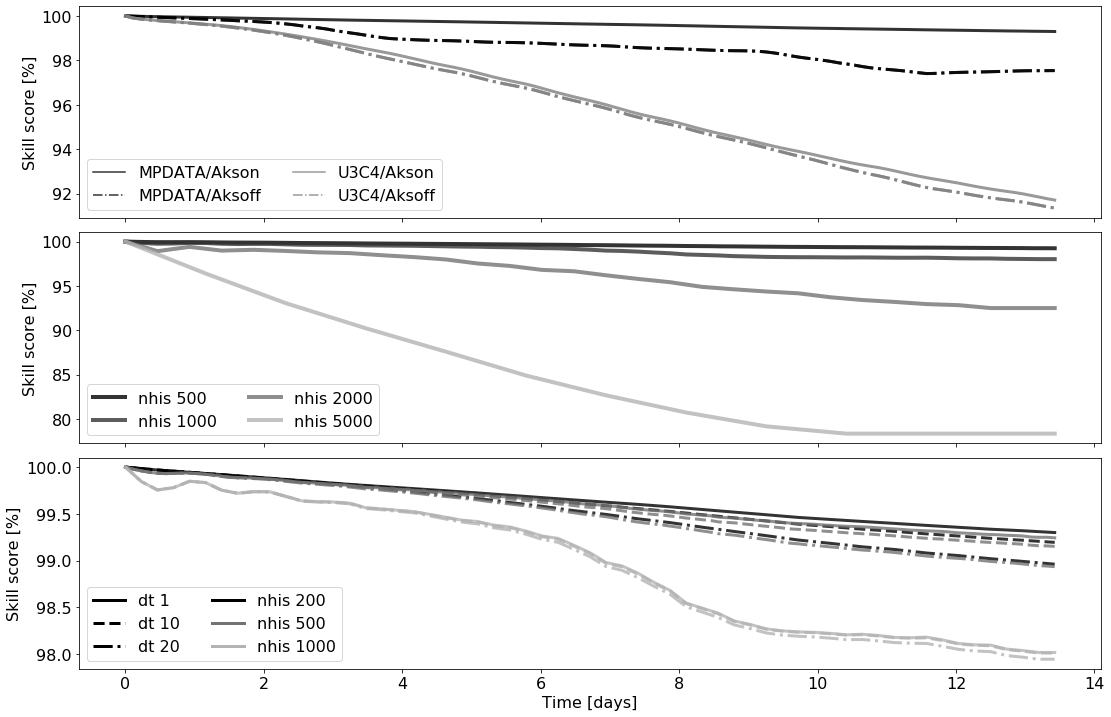

In [38]:
fig, axes = plt.subplots(3,1,figsize=(15,10), sharex=True)#, sharey=True)

# demonstrate tracer advection schemes and Aks forcing for nhis/dt=1
ax = axes[0]
ax.plot(dfhis[iAksonMPDATA], colMPDATA, alpha=alpha, ls=lsAkson, lw=3)
ax.plot(dfhis[iAksoffMPDATA], colMPDATA, alpha=alpha, ls=lsAksoff, lw=3)
ax.plot(dfhis[iAksonU3C4], colU3C4, alpha=alpha, ls=lsAkson, lw=3)
ax.plot(dfhis[iAksoffU3C4], colU3C4, alpha=alpha, ls=lsAksoff, lw=3)

ax.plot([], label="MPDATA/Akson", color=colMPDATA, alpha=alpha, ls=lsAkson)  
ax.plot([], label="MPDATA/Aksoff", color=colMPDATA, alpha=alpha, ls=lsAksoff)  
ax.plot([], label="U3C4/Akson", color=colU3C4, alpha=alpha, ls=lsAkson)  
ax.plot([], label="U3C4/Aksoff", color=colU3C4, alpha=alpha, ls=lsAksoff)  


# demonstrate overall spread of nhis for dt=1
ax = axes[1]
for col, label, color in zip(colsnhis, labelsnhis, colorsnhis):#, colstc, colstls):
    ax.plot(dfhis[col], label=label, color=color, alpha=alpha, lw=4)



# demonstrate spread of dt for a few important nhis
ax = axes[2]
# ax.plot(dfhis[ihis], colhis, alpha=alpha)
# ax.plot(dfavg[iavg], colavg, alpha=alpha);

for col, c, ls, label in zip(colst, colorst, lst, labelst):
    ax.plot(dfhis[col], color=c, alpha=alpha, ls=ls, lw=3)
for ls, dt in zip(lss, dts):
    ax.plot([], label="dt %i" % dt, color='k', lw=3, ls=ls)
for c, nhis in zip(colors, nhist):
    ax.plot([], label="nhis %i" % nhis, color=c, lw=3)


ax.set_xlabel('Time [days]', fontsize=16)

fig.tight_layout()

for ax in axes.flat:
    ax.tick_params(labelsize=16)
    ax.legend(fontsize=16, ncol=2)
    ax.set_ylabel('Skill score [%]', fontsize=16)



The best performance comes from the MPDATA tracer advection schemes and forcing realistic Aks values from the online case. Using MPDATA without forcing realistic Aks values (using instead a constant value, whose value was found to be unimportant) is still better than using the U3/C4 tracer advection schemes. 

The importance of nhis is low as nhis increases until 200. As nhis increases beyond 200, there is a noticeable decrease in skill score with nhis=500, though performance is reasonably high still, but as nhis increases beyond 500, performance decreases drastically.

For nhis equal to 200 or less, the offline forcing time step is more important than the nhis value. For example, forcing the offline simulation with nhis=20 and dt=20 performs worse than forcing with nhis=200 and dt=10. So, in our case there is no reason to save output more frequently than nhis=200.



In [439]:
fname = 'output_ss/dfhis_persist.csv'
dfhis = pd.read_csv(fname, index_col='ocean_time')
# fname = 'output_ss/dfavg_persist.csv'
# dfavg = pd.read_csv(fname, index_col='ocean_time')

In [441]:
alpha=0.8
cols = [col for col in dfhis.columns if 'dt50' not in col]
colsa = [col for col in dfavg.columns if 'dt50' not in col]

# Tracer advection schemes and Aks forcing or not
iMPDATA = [col for col in cols if 'MPDATA' in col and '_nhis1_' in col and 'dt50' not in col and '_nhis5000_' not in col]
colMPDATA = 'k'
iU3C4 = [col for col in cols if 'U3C4' in col and '_nhis1_' in col and 'dt50' not in col and '_nhis5000_' not in col]
colU3C4 = '0.5'

iAksonMPDATA = [col for col in iMPDATA if 'Akson' in col]
lsAkson = '-'
iAksoffMPDATA = [col for col in iMPDATA if 'Aksoff' in col]
lsAksoff = '-.'
iAksonU3C4 = [col for col in iU3C4 if 'Akson' in col]
iAksoffU3C4 = [col for col in iU3C4 if 'Aksoff' in col]

# # his vs avg file forcing
# ihis = [col for col in cols if 'MPDATA' in col and '_nhis2_' in col and 'dt50' not in col]# and 'dt10' in col]
# colhis = 'k'
# iavg = [col for col in colsa if 'MPDATA' in col and '_nhis2_' in col and 'dt50' not in col]# and 'dt10' in col]
# colavg = 'r'

colors = ['0.0', '0.2', '0.45', '0.7']
colorsnhis = []
labelsnhis = []
nhist = [500,1000,2000,5000]  # everything lower than 200 is indistinguishable from 200
for (i, nhis), color in zip(enumerate(nhist), colors):
    if dt>=50 or dt>nhis:
        continue
    if nhis==50 and dt==20:
        continue
    colsnhis.append([col for col in cols if 'nhis%i_' % nhis in col and 'dt1' in col
                  and not 'dt10' in col and 'MPDATA' in col and 'Akson' in col])
    labelsnhis.append('nhis %i' % nhis)
    colorsnhis.append(color)
        
        


colors = ['0.0', '0.45', '0.7']
lss = ['-', '--', '-.', ':']
colst = []
colorst = []  # colors to go with columns
lst = []  # linestyles to go with columns
labelst = []
nhist = [200,500,1000]  # everything lower than 200 is indistinguishable from 200
dts = [1, 10, 20]  # dt=2 indistinguishable from dt=1

for (i, nhis), color in zip(enumerate(nhist), colors):
    for dt, ls in zip(dts, lss):
        if dt>=50 or dt>nhis:
            continue
        if nhis==50 and dt==20:
            continue
        colst.append([col for col in cols if 'nhis%i_' % nhis in col and 'dt%i' % dt in col
                      and not 'dt%i' % (dt*10) in col and 'MPDATA' in col and 'Akson' in col])
        colorst.append(color)
        lst.append(ls)
        labelst.append('nhis %i/dt %i' % (nhis,dt))
        

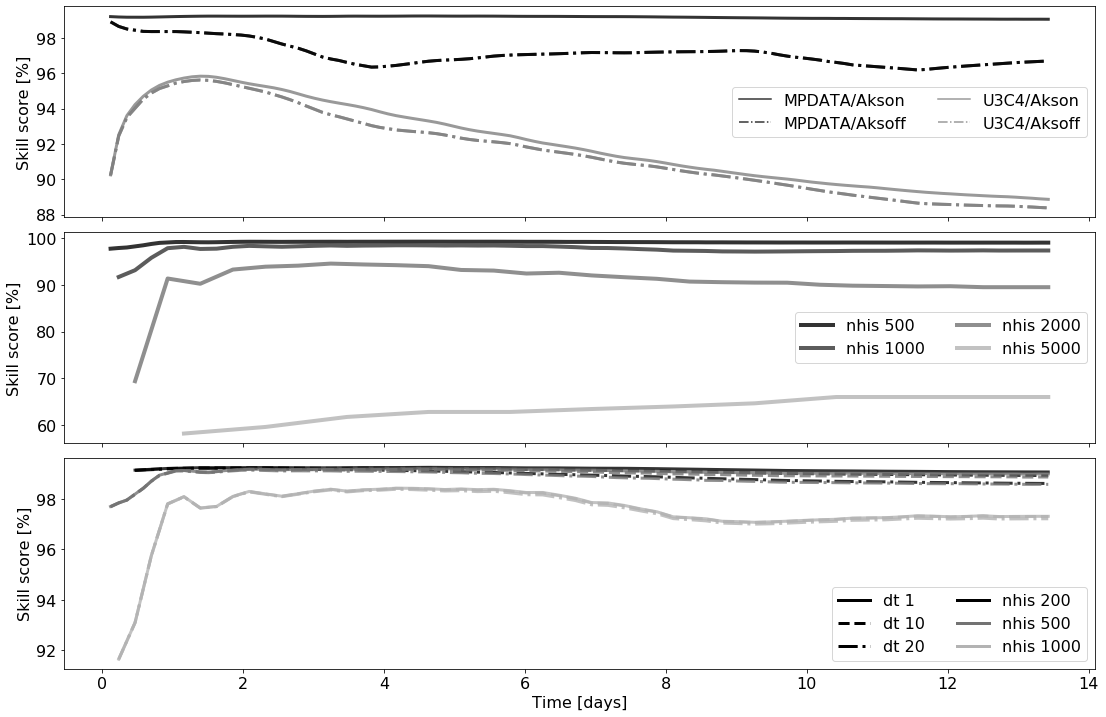

In [442]:
fig, axes = plt.subplots(3,1,figsize=(15,10), sharex=True)#, sharey=True)

# demonstrate tracer advection schemes and Aks forcing for nhis/dt=1
ax = axes[0]
ax.plot(dfhis[iAksonMPDATA], colMPDATA, alpha=alpha, ls=lsAkson, lw=3)
ax.plot(dfhis[iAksoffMPDATA], colMPDATA, alpha=alpha, ls=lsAksoff, lw=3)
ax.plot(dfhis[iAksonU3C4], colU3C4, alpha=alpha, ls=lsAkson, lw=3)
ax.plot(dfhis[iAksoffU3C4], colU3C4, alpha=alpha, ls=lsAksoff, lw=3)

ax.plot([], label="MPDATA/Akson", color=colMPDATA, alpha=alpha, ls=lsAkson)  
ax.plot([], label="MPDATA/Aksoff", color=colMPDATA, alpha=alpha, ls=lsAksoff)  
ax.plot([], label="U3C4/Akson", color=colU3C4, alpha=alpha, ls=lsAkson)  
ax.plot([], label="U3C4/Aksoff", color=colU3C4, alpha=alpha, ls=lsAksoff)  


# demonstrate overall spread of nhis for dt=1
ax = axes[1]
for col, label, color in zip(colsnhis, labelsnhis, colorsnhis):#, colstc, colstls):
    ax.plot(dfhis[col], label=label, color=color, alpha=alpha, lw=4)



# demonstrate spread of dt for a few important nhis
ax = axes[2]
# ax.plot(dfhis[ihis], colhis, alpha=alpha)
# ax.plot(dfavg[iavg], colavg, alpha=alpha);

for col, c, ls, label in zip(colst, colorst, lst, labelst):
    ax.plot(dfhis[col], color=c, alpha=alpha, ls=ls, lw=3)
for ls, dt in zip(lss, dts):
    ax.plot([], label="dt %i" % dt, color='k', lw=3, ls=ls)
for c, nhis in zip(colors, nhist):
    ax.plot([], label="nhis %i" % nhis, color=c, lw=3)


ax.set_xlabel('Time [days]', fontsize=16)

fig.tight_layout()

for ax in axes.flat:
    ax.tick_params(labelsize=16)
    ax.legend(fontsize=16, ncol=2)
    ax.set_ylabel('Skill score [%]', fontsize=16)

    


## his vs avg

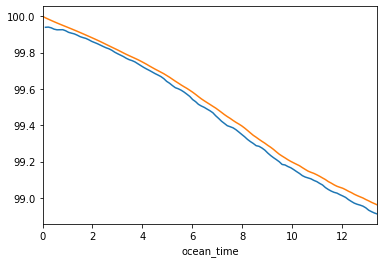

In [438]:
ax = dfavg['MPDATA_Akson_avg_nhis20_dt20'].plot()
dfhis['MPDATA_Akson_his_nhis20_dt20'].plot(ax=ax)